# SenNet + HOA - Hacking the Human Vasculature in 3D

## Importing Libraries

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import tifffile as tiff
import cv2
import torch.nn as nn
import albumentations as A
import numpy as np
import os
import time
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go

In [2]:
!nvidia-smi

Sun Feb  4 15:57:05 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 ...  WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   37C    P8              13W / 120W |    172MiB /  6144MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Sample Original Image & Label

In [3]:
KIDNEY_FOLDER = ['kidney_1_dense',
 'kidney_1_voi',
 'kidney_2',
 'kidney_3_sparse']

BASE_PATH = 'kaggle\\input\\blood-vessel-segmentation\\train' # local host 
# base_path = '/kaggle/input/blood-vessel-segmentation/train' # kaggle host

In [8]:
def get_tif_paths(root_folder):
    images_path, labels_path = [], []
    
    for i in KIDNEY_FOLDER:
        kidney_folder_path = os.path.join(root_folder, f'{i}')
        # Iterate over the images and labels folders within each kidney folder
        for data_type in ['images', 'labels']:
            data_folder_path = os.path.join(kidney_folder_path, data_type)

            # Collect paths of .tif files within each data folder
            for file_name in os.listdir(data_folder_path):
                if file_name.endswith(".tif"):
                    file_path = os.path.join(data_folder_path, file_name)
                    
                    if data_type == 'images':
                        images_path.append(file_path)
                    else:
                        labels_path.append(file_path)

    return images_path, labels_path

images_path, labels_path = get_tif_paths(BASE_PATH)

In [41]:

# dataset  = os.listdir(base_path)

# images_path = [os.path.join(base_path, i, 'images') for i in dataset]
# labels_path = [os.path.join(base_path, i, 'labels') for i in dataset]

# image_files = sorted([os.path.join('', images_path+ f) for f in os.listdir(images_path) if f.endswith('.tif')])
# label_files = sorted([os.path.join('', labels_path+ f) for f in os.listdir(labels_path) if f.endswith('.tif')])

def show_images(images,titles= None, cmap='gray'):
    n = len(images)
    fig = make_subplots(1, n)
    for i, img in enumerate(images):
        figg = px.imshow(img, binary_string=True, width = 400)
        fig.add_trace(figg.data[0], row =  i//2 +1, col = i%2 +1)
    
    fig.update_layout(height = 500, width =1000)
    fig.show()

first_image = tiff.imread(BASE_PATH[981])
first_label = tiff.imread(label_files[981])

show_images([first_image, first_label], titles=['First Image', 'First Label'])

IndexError: list index out of range

## Dataloader

In [4]:

class CustomDataset(Dataset):
    def __init__(self, image_files, mask_files, input_size=(256, 256), augmentation_transforms=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.input_size = input_size
        self.augmentation_transforms = augmentation_transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
       
        image_path = self.image_files[idx]
        mask_path = self.mask_files[idx]

        image = preprocess_image(image_path)
        mask = preprocess_mask(mask_path)

        if self.augmentation_transforms:
            image, mask = self.augmentation_transforms(image, mask)

        return image, mask

## Preprocessing of Images

In [5]:
def preprocess_image(path):
    
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = np.tile(img[...,None],[1, 1, 3]) 
    img = img.astype('float32') 
    mx = np.max(img)
    if mx:
        img/=mx 
        
    img = np.transpose(img, (2, 0, 1))
    img_ten = torch.tensor(img)
    return img_ten

## Preprocessing of Masks

In [6]:
def preprocess_mask(path):
    
    msk = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    msk = msk.astype('float32')
    msk/=255.0
    msk_ten = torch.tensor(msk)
    
    return msk_ten

## Augmentation

In [7]:
def augment_image(image, mask):
    
    image_np = image.permute(1, 2, 0).numpy()
    mask_np = mask.numpy()

    transform = A.Compose([
        A.Resize(256,256, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        A.RandomCrop(height=256, width=256, always_apply=True),
        A.RandomBrightness(p=1),
        A.OneOf(
            [
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
    
    ])

    augmented = transform(image=image_np, mask=mask_np)
    augmented_image, augmented_mask = augmented['image'], augmented['mask']

    augmented_image = torch.tensor(augmented_image, dtype=torch.float32).permute(2, 0, 1)
    augmented_mask = torch.tensor(augmented_mask, dtype=torch.float32)

    return augmented_image, augmented_mask

In [8]:
base_path = 'kaggle/input/blood-vessel-segmentation/train'  

dataset = 'kidney_1_dense'

images_path = os.path.join(base_path, dataset, 'images')
labels_path = os.path.join(base_path, dataset, 'labels')

image_files = sorted([os.path.join(images_path, f) for f in os.listdir(images_path) if f.endswith('.tif')])
label_files = sorted([os.path.join(labels_path, f) for f in os.listdir(labels_path) if f.endswith('.tif')])

## Splitting the Dataset

In [9]:
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(
    image_files, label_files, test_size=0.2, random_state=42)

In [10]:
train_dataset = CustomDataset(train_image_files, train_mask_files, augmentation_transforms=augment_image)
val_dataset = CustomDataset(val_image_files, val_mask_files, augmentation_transforms=augment_image)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

## Augmented Batch_1 Images & Labels Viz.

C:\Users\Sharks & Bears\AppData\Roaming\Python\Python39\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning:

This class has been deprecated. Please use RandomBrightnessContrast



Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])


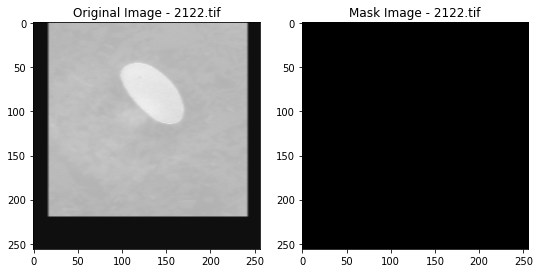

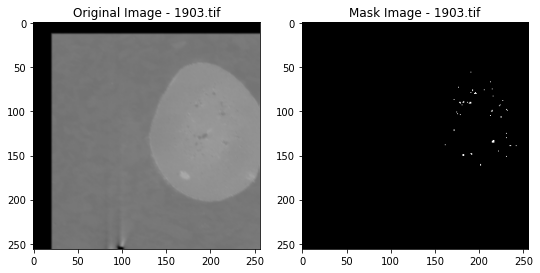

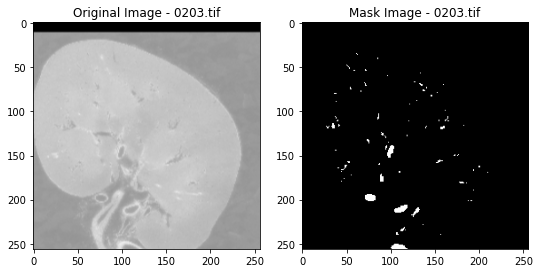

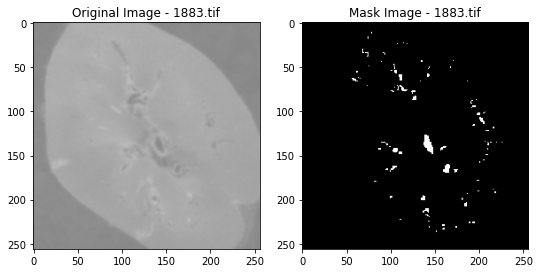

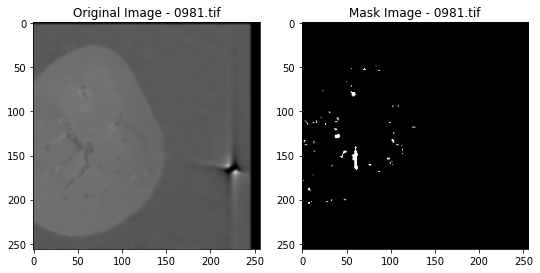

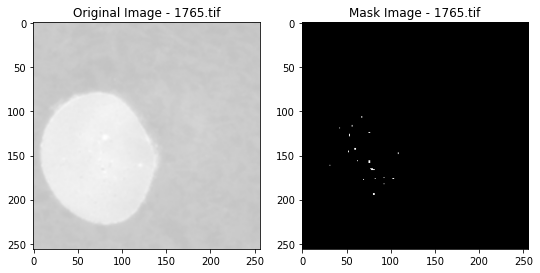

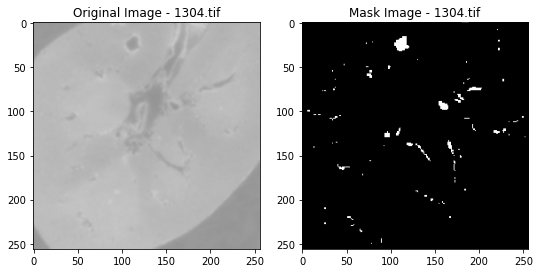

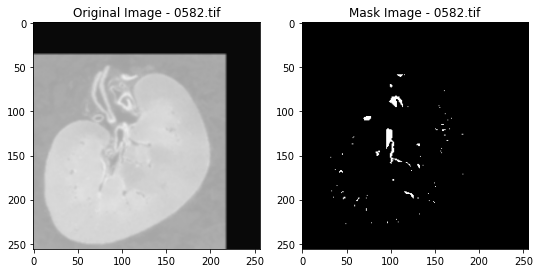

In [12]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)
    
    for image, mask, image_path, mask_path in zip(batch_images, batch_masks, train_image_files, train_mask_files):
       
        image = image.permute((1, 2, 0)).numpy()*255.0
        image = image.astype('uint8')
        mask = (mask*255).numpy().astype('uint8')
        
        image_filename = os.path.basename(image_path)
        mask_filename = os.path.basename(mask_path)
        
        plt.figure(figsize=(15, 10))
        
        plt.subplot(2, 4, 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Original Image - {image_filename}")
        
        plt.subplot(2, 4, 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f"Mask Image - {mask_filename}")
        
        plt.tight_layout()
        plt.show()
    break

In [13]:
for batch_idx, (batch_images, batch_masks) in enumerate(train_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 2
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 3
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 4
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 5
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 6
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 7
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 8
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 9
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 10
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])

In [14]:
for batch_idx, (batch_images, batch_masks) in enumerate(val_dataloader):
    print("Batch", batch_idx + 1)
    print("Image batch shape:", batch_images.shape)
    print("Mask batch shape:", batch_masks.shape)

Batch 1
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 2
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 3
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 4
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 5
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 6
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 7
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 8
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 9
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])
Batch 10
Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 256, 256])

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
device = get_default_device()
device

device(type='cuda')

## Attention U-Net architecture

One thing that is worth noticing, is that I had to add some black padding around images. It is because, I am using U-Net - like architecture with learnable visual attention blocks, and spatial dimensions of signal coming from skip connections and their corresponging feature maps must fit together. That is why the pictures after padding have size (592, 576) - they can be downsampled using max pooling 4 times (the dimensions are possible to divide by 4).

The picture that helps to understand the U-Net architecture is given below. It is a encoder-decoder architecture, that means that input image is first downsampled using max pooling. This process produces feature maps, that is semantic features coming from imput image. Then, the feature maps are upsampled again, to classify each pixel in the image. To make this process more accurate, authors of the architecture decided to use skip connections: signal from feature maps is combined with input image. It helps to decide precisely, which picture should be considered positive class (in this case: blood vessel) and which one should be marked as a background.

The picture's source is the U-Net paper.

![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

Recently, the field of Deep Learning is evolving extremely fast. New ideas and architectures are proposed frequently. One of them, that helped to improve NLP is attention. It is an idea that we can try to make our model focus on certain parts of the incoming signal (in case of text: sequences of words, in case of images: matrices with their digital representation). Computer Vision community, inspired by the work of their colleagues, have developed an idea of visual attention. For example the paper "Learn to pay attention" by Jetley et al describes the usage of learnable attention gate, that is additional blocks that gather signals from different layers of the network and learn where useful information from the image is. The prediction is made by concatenating the output from the attention blocks, and not by making use of the last layer of the network directly. The image from the article that describes the idea is given below: ![alt text](https://miro.medium.com/max/616/0*8r63L3yR66SVBgJR)

This idea was futher developed for semantic segmentation tasks by Oktay et al in the article "Attention U-Net: Learning Where to Look for the Pancreas". The difference is that attention blocks are now learning to filter signal from skip connections by estimating the information coming from them by comparing it with features from feature maps.
![alt text](https://miro.medium.com/max/780/1*PdYEf-OuUWkRsm2Lfrmy6A.png)


I decided to use this idea for my dataset, because it might work quite well, and also I would learn a lot.

In [16]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class UpConv(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()

        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x


class AttentionBlock(nn.Module):
    """Attention block with learnable parameters"""

    def __init__(self, F_g, F_l, n_coefficients):
        """
        :param F_g: number of feature maps (channels) in previous layer
        :param F_l: number of feature maps in corresponding encoder layer, transferred via skip connection
        :param n_coefficients: number of learnable multi-dimensional attention coefficients
        """
        super(AttentionBlock, self).__init__()

        self.W_gate = nn.Sequential(
            nn.Conv2d(F_g, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, n_coefficients, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(n_coefficients)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(n_coefficients, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, gate, skip_connection):
        """
        :param gate: gating signal from previous layer
        :param skip_connection: activation from corresponding encoder layer
        :return: output activations
        """
        g1 = self.W_gate(gate)
        x1 = self.W_x(skip_connection)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = skip_connection * psi
        return out


class AttentionUNet(nn.Module):

    def __init__(self, img_ch=3, output_ch=1):
        super(AttentionUNet, self).__init__()

        self.MaxPool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = ConvBlock(img_ch, 64)
        self.Conv2 = ConvBlock(64, 128)
        self.Conv3 = ConvBlock(128, 256)
        self.Conv4 = ConvBlock(256, 512)
        self.Conv5 = ConvBlock(512, 1024)

        self.Up5 = UpConv(1024, 512)
        self.Att5 = AttentionBlock(F_g=512, F_l=512, n_coefficients=256)
        self.UpConv5 = ConvBlock(1024, 512)

        self.Up4 = UpConv(512, 256)
        self.Att4 = AttentionBlock(F_g=256, F_l=256, n_coefficients=128)
        self.UpConv4 = ConvBlock(512, 256)

        self.Up3 = UpConv(256, 128)
        self.Att3 = AttentionBlock(F_g=128, F_l=128, n_coefficients=64)
        self.UpConv3 = ConvBlock(256, 128)

        self.Up2 = UpConv(128, 64)
        self.Att2 = AttentionBlock(F_g=64, F_l=64, n_coefficients=32)
        self.UpConv2 = ConvBlock(128, 64)

        self.Conv = nn.Conv2d(64, output_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        """
        e : encoder layers
        d : decoder layers
        s : skip-connections from encoder layers to decoder layers
        """
        e1 = self.Conv1(x)

        e2 = self.MaxPool(e1)
        e2 = self.Conv2(e2)

        e3 = self.MaxPool(e2)
        e3 = self.Conv3(e3)

        e4 = self.MaxPool(e3)
        e4 = self.Conv4(e4)

        e5 = self.MaxPool(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)

        s4 = self.Att5(gate=d5, skip_connection=e4)
        d5 = torch.cat((s4, d5), dim=1) 
        d5 = self.UpConv5(d5)

        d4 = self.Up4(d5)
        s3 = self.Att4(gate=d4, skip_connection=e3)
        d4 = torch.cat((s3, d4), dim=1)
        d4 = self.UpConv4(d4)

        d3 = self.Up3(d4)
        s2 = self.Att3(gate=d3, skip_connection=e2)
        d3 = torch.cat((s2, d3), dim=1)
        d3 = self.UpConv3(d3)

        d2 = self.Up2(d3)
        s1 = self.Att2(gate=d2, skip_connection=e1)
        d2 = torch.cat((s1, d2), dim=1)
        d2 = self.UpConv2(d2)

        out = self.Conv(d2)

        return out

## Dice Coefficient

For segmenation task, Dice Coefficient is often used to measure performance of the models. I havn't used it as a loss function directly, because I read that training the model with such loss function is not always stable. I decided to use Focal loss, because it has this nice property that it focuses on imbalanced positive class. It was developed for object detection, but it can be used for segmenation too. In the dataset that I am using there is quite a big class imbalance - most of the pixels don't represent blood vessels.

The picture below help us understand Dice Coefficient intuitevely. It is a 2 * |AnB| / (|A| + |B|)

![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Intersection_of_sets_A_and_B.svg/1200px-Intersection_of_sets_A_and_B.svg.png)


In [17]:
def dice_coeff(prediction, target):

    mask = np.zeros_like(prediction)
    mask[prediction >= 0.5] = 1

    inter = np.sum(mask * target)
    union = np.sum(mask) + np.sum(target)
    epsilon = 1e-6
    result = np.mean(2 * inter / (union + epsilon))
    return result

## Focal Loss


The plot helped me understand the Focal Loss. It comes from the Focal Loss paper.
![alt text](https://miro.medium.com/max/1032/1*wLf0KMIzBsXPcxsN7yBrIA.png)

In [18]:
class FocalLoss(nn.modules.loss._WeightedLoss):

    def __init__(self, gamma=0, size_average=None, ignore_index=-100,
                 reduce=None, balance_param=1.0):
        super(FocalLoss, self).__init__(size_average)
        self.gamma = gamma
        self.size_average = size_average
        self.ignore_index = ignore_index
        self.balance_param = balance_param

    def forward(self, input, target):
        
        assert len(input.shape) == len(target.shape)
        assert input.size(0) == target.size(0)
        assert input.size(1) == target.size(1)

        logpt = - F.binary_cross_entropy_with_logits(input, target)
        pt = torch.exp(logpt)

        focal_loss = -((1 - pt) ** self.gamma) * logpt
        balanced_focal_loss = self.balance_param * focal_loss
        return balanced_focal_loss

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE

In [20]:
dataloaders = {
    'training': train_dataloader,
    'test': val_dataloader
}

## Training and Testing Loop

In [21]:
def train_and_test(model, dataloaders, optimizer, criterion, num_epochs=100, show_images=False):
    since = time.time()
    best_loss = 1e10
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    fieldnames = ['epoch', 'training_loss', 'test_loss', 'training_dice_coeff', 'test_dice_coeff']
    train_epoch_losses = []
    test_epoch_losses = []
    model_weights = [model.state_dict()]
    for epoch in range(1, num_epochs + 1):
        
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)
        
        batchsummary = {a: [0] for a in fieldnames}
        batch_train_loss = 0.0
        batch_test_loss = 0.0

        for phase in ['training', 'test']:
            if phase == 'training':
                model.train()  
            else:
                model.eval() 

            for sample in iter(dataloaders[phase]):

                if show_images:
                    grid_img = make_grid(sample[0])
                    grid_img = grid_img.permute(1, 2, 0)
                    plt.imshow(grid_img)
                    plt.show()

                inputs = sample[0].to(device)
                masks = sample[1].to(device)
                
                masks = masks.unsqueeze(1)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'training'):
                    outputs = model(inputs)

                    loss = criterion(outputs, masks)

                    y_pred = outputs.data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()

                    batchsummary[f'{phase}_dice_coeff'].append(dice_coeff(y_pred, y_true))

                    if phase == 'training':
                        loss.backward()
                        optimizer.step()

                        batch_train_loss += loss.item() * sample[0].size(0)

                    else:
                        batch_test_loss += loss.item() * sample[0].size(0)

            if phase == 'training':
                epoch_train_loss = batch_train_loss / len(dataloaders['training'])
                train_epoch_losses.append(epoch_train_loss)
            else:
                epoch_test_loss = batch_test_loss / len(dataloaders['test'])
                test_epoch_losses.append(epoch_test_loss)
            
            batchsummary['epoch'] = epoch
            
            print('{} Loss: {:.4f}'.format(phase, loss))

        best_loss = np.max(batchsummary['test_dice_coeff'])
        if epoch % 5 == 0: 
            model_weights.append(model.state_dict())
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(
            f'\t\t\t train_dice_coeff: {batchsummary["training_dice_coeff"]}, test_dice_coeff: {batchsummary["test_dice_coeff"]}')

    print('Best dice coefficient: {:4f}'.format(best_loss))

    return model, train_epoch_losses, test_epoch_losses, model_weights

In [22]:
epochs = 25

def train():
    model = AttentionUNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    # criterion = FocalLoss(gamma=2)
    criterion = DiceBCELoss()
    trained_model, train_epoch_losses, test_epoch_losses, model_weights = train_and_test(model, dataloaders, optimizer, criterion, num_epochs=epochs)

    return trained_model, train_epoch_losses, test_epoch_losses, model_weights


trained_model, train_epoch_losses, test_epoch_losses, model_weights = train()

Epoch 1/25
----------
training Loss: 1.2958
test Loss: 1.2972
			 train_dice_coeff: 0.0033867530104899047, test_dice_coeff: 0.00025155772268092467
Epoch 2/25
----------
training Loss: 1.2149
test Loss: 1.1965
			 train_dice_coeff: 0.0004803322894427801, test_dice_coeff: 0.0011382461077383559
Epoch 3/25
----------
training Loss: 1.1038
test Loss: 1.1277
			 train_dice_coeff: 0.3022074461123773, test_dice_coeff: 0.42005340700923666
Epoch 4/25
----------
training Loss: 1.0502
test Loss: 1.0417
			 train_dice_coeff: 0.45377412255902466, test_dice_coeff: 0.48424862560390286
Epoch 5/25
----------
training Loss: 0.9934
test Loss: 0.9928
			 train_dice_coeff: 0.4951441966590814, test_dice_coeff: 0.46264908033818214
Epoch 6/25
----------
training Loss: 0.8891
test Loss: 0.9171
			 train_dice_coeff: 0.5195856144216345, test_dice_coeff: 0.5078689172884995
Epoch 7/25
----------
training Loss: 0.6648
test Loss: 0.8750
			 train_dice_coeff: 0.5493661477552342, test_dice_coeff: 0.514788837387533
Epoc

In [23]:
SAVE_NAME = 'DiceBCE'
torch.save(trained_model.state_dict(), SAVE_NAME + '.pth')

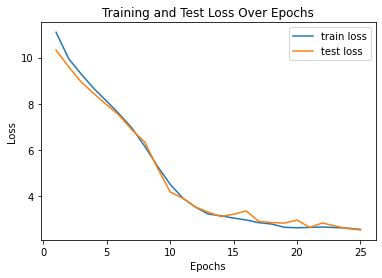

In [24]:
train_plot, = plt.plot(range(1, len(train_epoch_losses) + 1), train_epoch_losses, label='train loss')
test_plot, = plt.plot(range(1, len(test_epoch_losses) + 1), test_epoch_losses, label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.show()


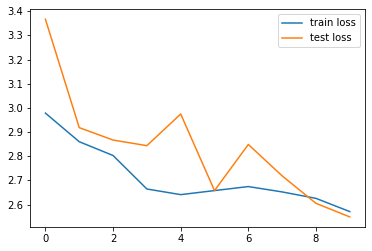

In [25]:
train_plot, = plt.plot(range(len(train_epoch_losses)-15), train_epoch_losses[15:], label='train loss')
test_plot, = plt.plot(range(len(test_epoch_losses)-15), test_epoch_losses[15:], label='test loss')
plt.legend(handles=[train_plot, test_plot])
plt.show()

In [26]:
import dill
filename = SAVE_NAME + '.pkl'
dill.dump_session(filename)

# # and to load the session again:
# dill.load_session(filename)